In [1]:
import numpy as np
import pandas as pd

import glob
import os
import textwrap

import geopandas
import cartopy.io.img_tiles as cimgt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy import config
from shapely.geometry import Point
from shapely.prepared import prep
import cartopy

import shapely.geometry as sgeom
from shapely.ops import cascaded_union
from scipy.io import netcdf

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", module = "matplotlib\..*" )

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import colors as ccolors
from matplotlib.ticker import MaxNLocator

mycmap = matplotlib.cm.get_cmap('PiYG')

In [88]:
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_map_subunits'

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

shpfilename = shpreader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
df.loc[df['SOVEREIGNT'] == 'Somaliland', 'ISO_A2_EH'] = 'SO'
df.loc[df['NAME'] == 'Crimea', 'ISO_A2_EH'] = 'UA'
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

In [19]:
filename = '../data/geonames_UNSD_WUP_metadata.csv'
meta = pd.read_csv(filename, keep_default_na=False)
isos = pd.unique(meta['ISO'])
print(meta.shape)
meta.head()

(249, 25)


,ISO,ISO3,ISO-Numeric,fips,Country,Capital,Area(in sq km),Population,Continent,Income,...,Subregion Code,Subregion Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,77006,Europe,HI,...,39,Southern Europe,,,Andorra,20,AND,,,
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,9630959,WANA,HI,...,145,Western Asia,,,United Arab Emirates,784,ARE,,,
2,AF,AFG,4,AF,Afghanistan,Kabul,647500.0,37172386,Rest of Asia,LO,...,34,Southern Asia,,,Afghanistan,4,AFG,x,x,
3,AG,ATG,28,AC,Antigua and Barbuda,St. John's,443.0,96286,Latin America and the Caribbean,X,...,419,Latin America and the Caribbean,029,Caribbean,Antigua and Barbuda,28,ATG,,,x
4,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,Latin America and the Caribbean,X,...,419,Latin America and the Caribbean,029,Caribbean,Anguilla,660,AIA,,,x


In [20]:
thr = 3000
mini = meta[meta['Area(in sq km)'] < thr].copy()
maxi = meta[meta['Area(in sq km)'] >= thr].copy()
print(mini.shape)
mini.sort_values(by='Area(in sq km)', ascending=False).head()

(71, 25)


,ISO,ISO3,ISO-Numeric,fips,Country,Capital,Area(in sq km),Population,Continent,Income,...,Subregion Code,Subregion Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
243,WS,WSM,882,WS,Samoa,Apia,2944.0,196130,Oceania,X,...,61,Polynesia,,,Samoa,882,WSM,,,x
133,LU,LUX,442,LU,Luxembourg,Luxembourg,2586.0,607728,Europe,HI,...,155,Western Europe,,,Luxembourg,442,LUX,,,
187,RE,REU,638,RE,Reunion,Saint-Denis,2517.0,776948,Sub-Saharan Africa,HI,...,202,Sub-Saharan Africa,014,Eastern Africa,Réunion,638,REU,,,
117,KM,COM,174,CN,Comoros,Moroni,2170.0,832322,Sub-Saharan Africa,LO,...,202,Sub-Saharan Africa,014,Eastern Africa,Comoros,174,COM,x,,x
153,MU,MUS,480,MP,Mauritius,Port Louis,2040.0,1265303,Sub-Saharan Africa,UM,...,202,Sub-Saharan Africa,014,Eastern Africa,Mauritius,480,MUS,,,x


In [21]:
filename = '../data/geonames_cities500.txt'
popd = pd.read_table(filename, header=None, dtype={10:'str', 13:'str'}, keep_default_na=False)
print(popd.shape)
popdcolumns = ['geonameid', 'name', 'asciiname', 'alternatenames',
               'latitude', 'longitude', 'feature_class', 'feature_code',
               'country_code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code',
               'admin4_code', 'population', 'elevation','dem', 'timezone', 'modification_date']
popd.columns = popdcolumns
popd = popd.loc[:, ['asciiname', 'country_code', 'population', 'latitude', 'longitude']]

popd.head()

(198934, 19)


,asciiname,country_code,population,latitude,longitude
0,Andorra la Vella,AD,20430.0,42.50779,1.52109
1,Arinsal,AD,1419.0,42.57205,1.48453
2,Canillo,AD,3292.0,42.56760,1.59756
3,El Tarter,AD,1052.0,42.57952,1.65362
4,Encamp,AD,11223.0,42.53474,1.58014


In [22]:
geocenters = np.zeros((len(mini), 2))
for i,iso in enumerate(mini['ISO']):
    minilocs = popd[popd['country_code'] == iso]
    geocenter = minilocs.loc[:,['latitude','longitude']].mean(axis='index').values
    geocenters[i] = geocenter
mini['latitude'] = geocenters[:,0]
mini['longitude'] = geocenters[:,1]

featurecla Admin-0 map subunit
scalerank 5
LABELRANK 6
SOVEREIGNT United Kingdom
SOV_A3 GB1
ADM0_DIF 1
LEVEL 4
TYPE Overlay
TLC 1
ADMIN British Indian Ocean Territory
ADM0_A3 IOT
GEOU_DIF 0
GEOUNIT British Indian Ocean Territory
GU_A3 IOT
SU_DIF 1
SUBUNIT Diego Garcia Naval Support Facility
SU_A3 IOD
BRK_DIFF 1
NAME Diego Garcia NSF
NAME_LONG Diego Garcia Naval Support Facility
BRK_A3 B44
BRK_NAME Diego Garcia NSF
BRK_GROUP None
ABBREV Dieg. G.
POSTAL DG
FORMAL_EN Diego Garcia Naval Support Facility
FORMAL_FR None
NAME_CIAWF None
NOTE_ADM0 U.S.A.
NOTE_BRK Leased to U.S.A by U.K.; Claimed by Mauritius and Seychelles
NAME_SORT Diego Garcia Naval Support Facility
NAME_ALT None
MAPCOLOR7 6
MAPCOLOR8 6
MAPCOLOR9 6
MAPCOLOR13 3
POP_EST 3000.0
POP_RANK 4
POP_YEAR 2018
GDP_MD 7230.0
GDP_YEAR 2016
ECONOMY 2. Developed region: nonG7
INCOME_GRP 2. High income: nonOECD
FIPS_10 -99
ISO_A2 -99
ISO_A2_EH GB
ISO_A3 -99
ISO_A3_EH GBR
ISO_N3 -99
ISO_N3_EH 826


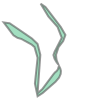

In [110]:
bar = df[~pd.isnull(df['NOTE_BRK'])]
foo = bar.iloc[25]
for c in df.columns[:50]:
    print(c,foo[c])
foo['geometry']

In [102]:
bar = df[(~pd.isnull(df['NOTE_BRK'])) & (df['ISO_A2_EH'] == '-99')]
bar['NAME']

6                           Dhekelia
26                Korean DMZ (south)
27                Korean DMZ (north)
146              USNB Guantanamo Bay
185                        N. Cyprus
187                  Siachen Glacier
190                         Akrotiri
191    Southern Patagonian Ice Field
193                        Bir Tawil
328                      Paracel Is.
337                      Spratly Is.
355                  Bajo Nuevo Bank
356                  Serranilla Bank
Name: NAME, dtype: object

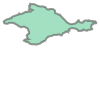

In [49]:
df[df['SOVEREIGNT'] == 'Russia']['geometry'].iloc[3]

In [113]:
colors = ['#0072B2', '#52ADE0', '#009E73', '#E69F00', '#D55E00', '#CC79A7', '#F0E442', '#555555']
labels = ['Europe', 'Northern America', 'China', 'Rest of Asia','Latin America and the Caribbean', 'Oceania', 'WANA', 'Sub-Saharan Africa']; clabels = ['Europe', 'Northern America', 'China', 'Rest of Asia','LATAM and Caribbean', 'Oceania', 'W Asia N Africa', 'SubSaharan Africa']; field='continent'
#labels = ['HI', 'UM', 'CN', 'LM', 'LO', 'X'];clabels = ['High Income', 'Upper Middle', 'China', 'Lower Middle', 'Low Income', 'Undefined']; field = 'income'

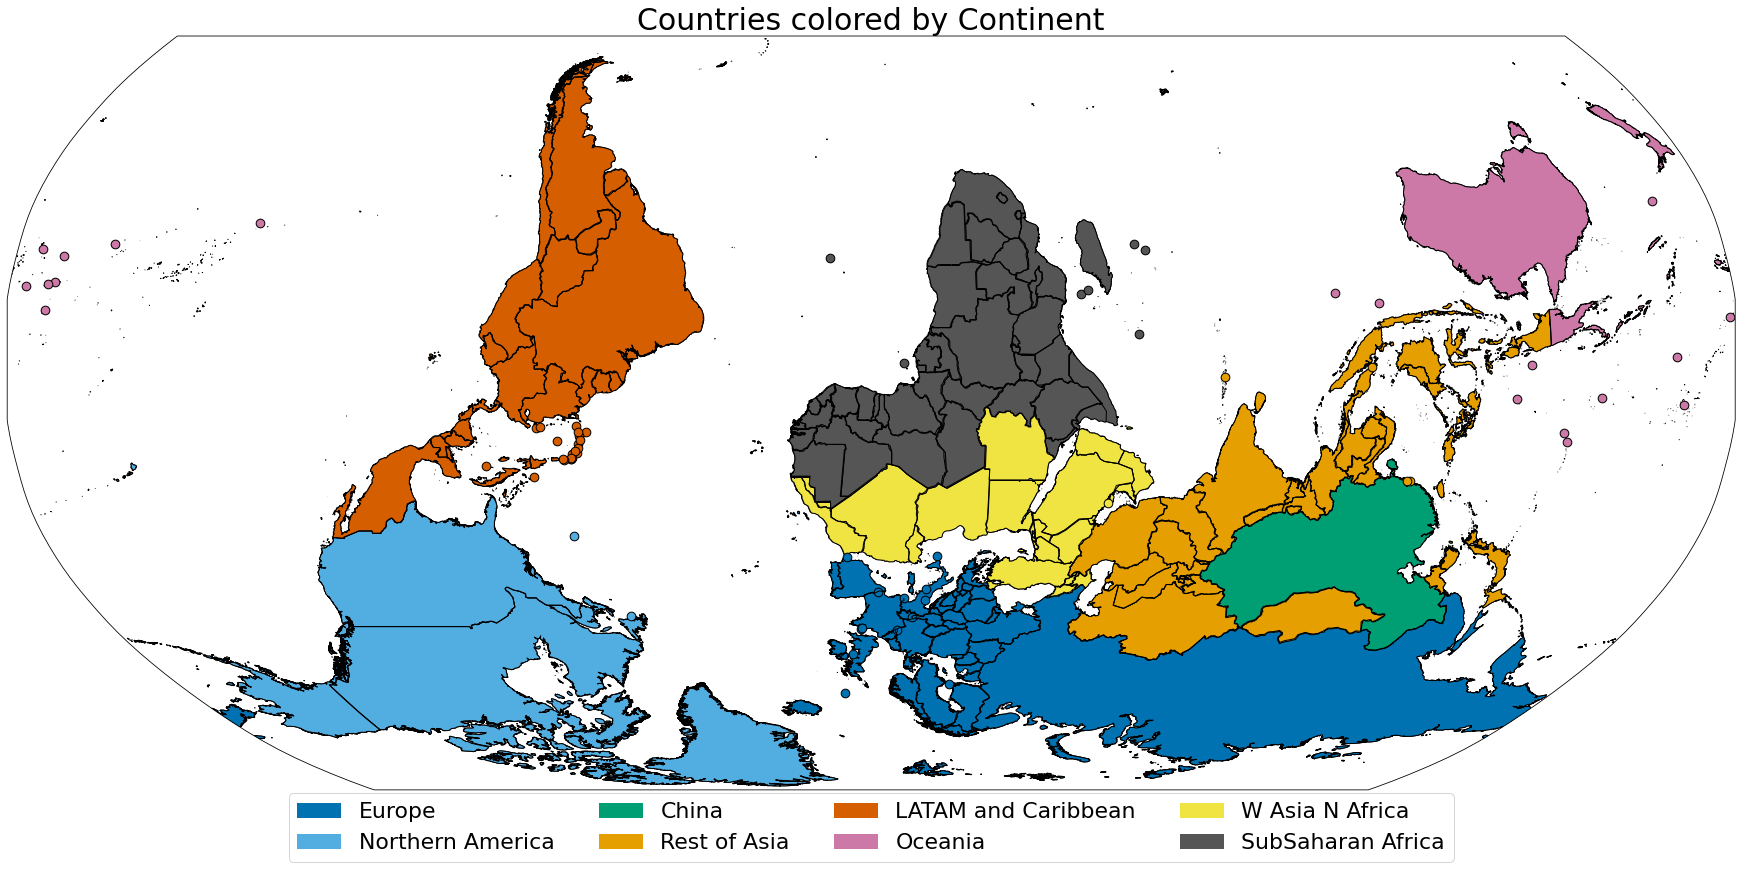

In [114]:
idx = 1
prj = ccrs.Robinson()
trn = ccrs.PlateCarree()

fig = plt.figure(figsize=(24, 12))

ax = fig.add_axes([0, 0, 1, 1], projection=prj)
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.set_title('Countries colored by ' + field.title(), fontsize=30)
ax.set_extent([-179,179,85,-60])

for idx in range(len(labels)):
#for idx in [5]:
    for iso in maxi[maxi[field.title()] == labels[idx]]['ISO']:
        geoms = [geom for geom in df[df['ISO_A2_EH'] == iso]['geometry']]
        geoms = cascaded_union(geoms)
        if geoms.geom_type == 'Polygon':
            geoms = [geoms]
        ax.add_geometries(geoms, crs=trn, facecolor=colors[idx], edgecolor='k', zorder=10)
    
    latlon = mini[mini[field.title()] == labels[idx]].loc[:, ['latitude','longitude']].dropna().values
    ax.scatter(latlon[:,1], latlon[:,0], transform=trn, 
               s=75, c=colors[idx], marker='o', alpha=1, zorder=12, edgecolor='k', linewidth=1)

lpatches = [mpatches.Rectangle((0, 0), 1, 1, facecolor=c) for c in colors] 
ax.legend(lpatches, clabels, fontsize=22, ncol=len(labels)//2,
          loc='lower center', bbox_to_anchor=(0.5, -0.11), fancybox=True)


filename = '../plots/countries_colored_by_' + field
plt.savefig(filename + '.jpg', dpi=600, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '_small.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

fig.gca().invert_yaxis()
filename = filename + '_inv'
plt.savefig(filename + '.jpg', dpi=600, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '_small.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')